In [ ]:
# You only need to run this once per machine
# !pip install -q -U bitsandbytes
# !pip install -q -U git+https://github.com/huggingface/transformers.git
# !pip install -q -U git+https://github.com/huggingface/peft.git
# !pip install -q -U git+https://github.com/huggingface/accelerate.git
# !pip install -q -U datasets scipy ipywidgets matplotlib

In [ ]:
# from accelerate import FullyShardedDataParallelPlugin, Accelerator
# from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

# fsdp_plugin = FullyShardedDataParallelPlugin(
#     state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
#     optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
# )

# accelerator = Accelerator(fsdp_plugin=fsdp_plugin)

### 1. Load Dataset

In [ ]:
from datasets import load_dataset

train_dataset = load_dataset('json', data_files='/home/z/Music/LLAMA/llama/IPG/datasets/new_train_data.json', split='train')  
eval_dataset = load_dataset('json', data_files='/home/z/Music/LLAMA/llama/IPG/datasets/new_test_data.json', split='train')

### Formatting prompts


```python
def formatting_func(example):
    text = f"### The following is a note by Eevee the Dog: {example['note']}"
    return text
```

In [ ]:
def formatting_func(example):
    text = f"### Job Description:\n{example['text']}\n\n### Required Skills:\n{example['skills']}"
    return text

### 2. Load Base Model

Let's now load Llama 2 13B - `meta-llama/Llama-2-13b-hf` - using 4 or 8-bit quantization!

In [5]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig


base_model_id = "meta-llama/Llama-2-13b-hf"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config)




In [6]:
# from transformers import AutoTokenizer, AutoModelForCausalLM
# import torch
# from bitsandbytes.optim import BitsAndBytesConfig

# base_model_id = "meta-llama/Llama-2-13b-hf"

# # 使用8-bit量化配置
# bnb_config = BitsAndBytesConfig(
#     load_in_4bit=False,  # 关闭4-bit加载
#     bnb_4bit_compute_dtype=torch.float32  # 使用标准的32-bit浮点数
# )

# model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config)


### 3. Tokenization

Set up the tokenizer. Add padding on the left as it [makes training use less memory](https://ai.stackexchange.com/questions/41485/while-fine-tuning-a-decoder-only-llm-like-llama-on-chat-dataset-what-kind-of-pa).


For `model_max_length`, it's helpful to get a distribution of your data lengths. Let's first tokenize without the truncation/padding, so we can get a length distribution.

In [7]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
    return_tensors="pt" 
)
tokenizer.pad_token = tokenizer.eos_token

# def generate_and_tokenize_prompt(prompt):
#     return tokenizer(formatting_func(prompt))

def generate_and_tokenize_prompt(prompt):
    text = prompt['text']
    skills = ', '.join(prompt['skills'])
    not_skills = ', '.join(prompt['not_skills'])

    # 对 text 进行标记化
    text_encoding = tokenizer(text, return_tensors="pt", padding='max_length', truncation=True, max_length=1300)

    # 对 skills 和 not_skills 进行标记化
    skills_encoding = tokenizer(skills, return_tensors="pt", padding='max_length', truncation=True, max_length=100)
    not_skills_encoding = tokenizer(not_skills, return_tensors="pt", padding='max_length', truncation=True, max_length=100)

    return {
        'input_ids': text_encoding['input_ids'].flatten(),
        'attention_mask': text_encoding['attention_mask'].flatten(),
        'skills_input_ids': skills_encoding['input_ids'].flatten(),
        'skills_attention_mask': skills_encoding['attention_mask'].flatten(),
        'not_skills_input_ids': not_skills_encoding['input_ids'].flatten(),
        'not_skills_attention_mask': not_skills_encoding['attention_mask'].flatten()
    }



# def generate_and_tokenize_prompt(prompt):
#     text = prompt['text']
#     skills = ', '.join(prompt['skills'])
#     not_skills = ', '.join(prompt['not_skills'])

#     # 对 text 进行标记化
#     text_encoding = tokenizer(text, return_tensors="pt", padding='max_length', truncation=True, max_length=1300)

#     # 标记化 skills 和 not_skills
#     # 请根据您的模型需求调整这里的处理方式
#     skills_encoding = tokenizer(skills, return_tensors="pt", padding='max_length', truncation=True, max_length=100)
#     not_skills_encoding = tokenizer(not_skills, return_tensors="pt", padding='max_length', truncation=True, max_length=100)

#     return {
#         'input_ids': text_encoding['input_ids'].flatten(),
#         'attention_mask': text_encoding['attention_mask'].flatten(),
#         'skills_input_ids': skills_encoding['input_ids'].flatten(),
#         'skills_attention_mask': skills_encoding['attention_mask'].flatten(),
#         'not_skills_input_ids': not_skills_encoding['input_ids'].flatten(),
#         'not_skills_attention_mask': not_skills_encoding['attention_mask'].flatten()
#     }
    # return {
    #     "input_ids_to_learn": features_to_learn['input_ids'],
    #     "attention_mask_to_learn": features_to_learn['attention_mask'],
    #     "input_ids_to_avoid": features_to_avoid['input_ids'],
    #     "attention_mask_to_avoid": features_to_avoid['attention_mask']
    #     # 可以添加更多字段，如 labels
    # }

Reformat the prompt and tokenize each sample:

In [8]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)

In [9]:
print(tokenized_train_dataset[6])  # 检查第一个样本是否包含 'skills' 和 'not_skills'



{'skills': ['leadership', 'sql', 'planning', 'devops', 'marketing', 'big data', 'crm', 'linkedin', 'agile', 'mentoring', 'cloud', 'web services', 'interpersonal', 'ai', 'communication', 'cost control', 'transformation', 'gcp', 'industrial', 'ml', 'saas', 'system', 'aws', 'business development', 'nlp', 'machine learning', 'multi-vendor teams. advanced talent', 'automation'], 'text': 'capability of building team, brand from the groud\nwide connection with potential clients\ngood understanding of AI, ML', 'id': '8247', 'not_skills': ['salesforce', 'mac', 'solution selling', 'spark', 'project management', 'vmware', 'hadoop', 'microsoft azure', 'account management', 'python', 'ios', 'oracle', 'support', 'linux', 'android', 'kubernetes'], 'input_ids': [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

Let's get a distribution of our dataset lengths, so we can determine the appropriate `max_length` for our input tensors.

2217


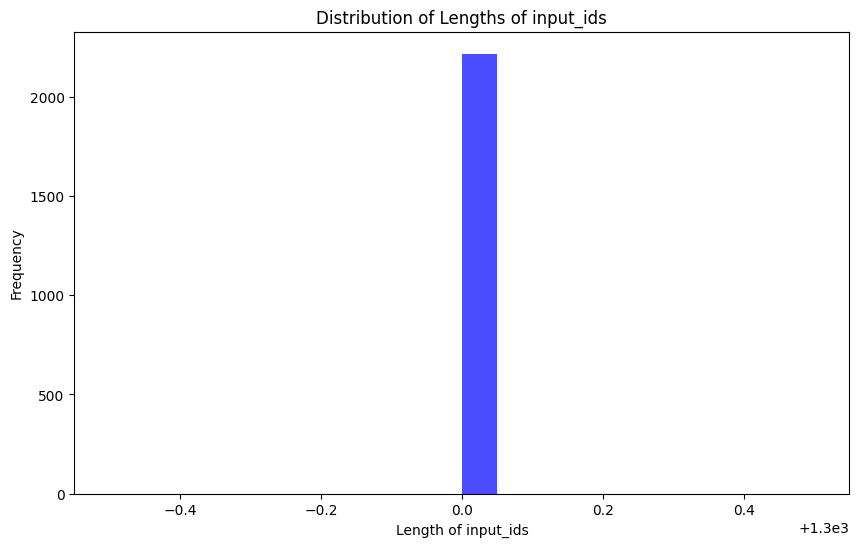

In [10]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenize_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

From here, you can choose where you'd like to set the `max_length` to be. You can truncate and pad training examples to fit them to your chosen size. Be aware that choosing a larger `max_length` has its compute tradeoffs. 

I'm using my personal notes to train the model, and they vary greatly in length. I spent some time cleaning the dataset so the samples were about the same length, cutting up individual notes if needed, but being sure to not cut in the middle of a word or sentence.

Now let's tokenize again with padding and truncation, and set up the tokenize function to make labels and input_ids the same. This is basically what [self-supervised fine-tuning is](https://neptune.ai/blog/self-supervised-learning).

In [11]:
# max_length = 1200
# def generate_and_tokenize_prompt2(prompt):
#     result = tokenizer(
#         formatting_func(prompt),
#         truncation=True,
#         max_length=max_length,
#         padding="max_length",
#     )
#     result["labels"] = result["input_ids"].copy()
#     return result

In [12]:
# max_length = 1500  # 设置最大长度

# def generate_and_tokenize_prompt2(prompt):
#     formatted_prompt = formatting_func(prompt)
#     result = tokenizer(
#         formatted_prompt,
#         truncation=True,  
#         max_length=max_length,  
#         padding="longest",  
#         return_tensors="pt",  
#         return_attention_mask=True  
#     )
    
#     # 复制input_ids到labels，用于模型训练的目标
#     result["labels"] = result["input_ids"].copy()
    
#     return result


In [13]:
# tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt2)
# tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt2)

Check that `input_ids` is padded on the left with the `eos_token` (2) and there is an `eos_token` 2 added to the end, and the prompt starts with a `bos_token` (1).

In [14]:
print(tokenized_train_dataset[1])

{'skills': ['leadership', 'php', 'tensorflow', 'sql', 'c++', 'matlab', 'seaborn', 'event management', 'matplotlib', 'git', 'powerpoint', 'riak', 'c sharp', 'scikit-learn', 'excel', 'rstudio', 'jdbc', 'libsvm', 'writing', 'pytorch', 'javascript', 'python', 'latex', 'node.js', 'c#', 'jupyter notebook'], 'text': 'Located in the Bay Area, Geneus Tech Inc. is a subsidiary/branch research center of its parent company in China, which is dedicated to the development and commercial application of 4th generation (nanopore-based) gene sequencing solutions, including devices, IC-MEMS chips, reagents, algorithms and software systems. The core technology platform is based on the detection and processing of characteristic current signals generated by the interaction between nanopore biosensors and nucleic acid bases. Thus, high-throughput sequencing of nucleic acids can be achieved at the single-molecule level through a highly integrated chip system.\nThis cutting-edge technology is highly expected t

Now all the samples should be the same length, `max_length`.

In [15]:
# plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [16]:
eval_prompt = """ ### The job description: \nPosition: Digital Manager/Director (Full time)\n \nAbout Red Harp\nRed Harp is an exciting new kind of agency for B2C brands looking to expand into new global markets. Our ‘Total Go-to-Market (GTM) Solution’ is a unique service offering encompassing branding, marketing, and commercial enablement to help companies quickly and effectively establish themselves in new markets. We’re a startup that is innovating the way global commerce works.\n \nAbout the Team\nThe Branding & Marketing Team at Red Harp partners with overseas clients on both brand and performance marketing efforts tailored to the US market – to drive awareness and favorability for long-term interest and purchase consideration, as well as in-market activation for short-term sales opportunities.\n \nPosition Overview\nRed Harp is looking for an enthusiastic candidate with first-hand experience in social media marketing to join the Team as our lead social community manager/director. This is a full-time employment position in our headquarters office located in Sunnyvale, CA.\n \nThe ideal candidate will lead management of social communications for clients, with responsibility for keeping existing audiences engaged while expanding the client’s reach and influence through strategic organic and paid activities. This will be a critical role for establishing and communicating our clients’ brand promise in the US market.\n \nResponsibilities\n\nDevelop and deploy a defined go-to market strategy for reaching and engaging target audiences\n\nHelp manage editorial calendars for our clients to support multiple ongoing social initiatives – on a quarterly, monthly, weekly, and daily basis (planned campaigns, as well as timely spontaneous activities)\nCoordinate with internal colleagues, contractors, partners, and client teams on the development and execution of social media strategy, content, creative, and other deliverables\nAuthor and deploy posts on clients’ owned social channels on a daily basis – across Twitter, Facebook, Instagram, blogs, and other platforms\n\n\n\n \n\nEngage in branded conversations\n\nIdentify and create strategic opportunities for the brand to engage target audiences in a two-way dialog – conversation prompts, questions, polls, live events, and other tactics\nHelp reach out to potential influencers and brand ambassadors with the aim of creating opportunities to produce content, extend reach, and generate earned media exposure\n\n\n\n \n\nManage paid social media activities\n\nCreate paid media plans to drive both A) brand engagement, and B) traffic to e-commerce channels\nManage ads on a daily basis to maximize the efficiency and effectiveness of client budgets\n\n\n\n \n\nBe data-driven\n\nServe as the eyes and ears for the brand, monitoring and reporting on user sentiment and interests, brand engagement, competitive activities, etc.\nAggregate performance data into a single comprehensive reporting tool\nAnalyze data and synthesize insights to inform future and ongoing social activities –identifying opportunities to optimize activities every week\nAssist with the creation of client reports and presentations\n\n\n\n\nRequirements\n\n5+ years of experience working for a brand, agency, or media company, with 3+ years of direct experience managing social media communities\nWorking knowledge of content marketing, paid media/advertising, influencer marketing, and other marketing disciplines\nAbility to engage intelligently with B2C audiences – to translate the brand’s messaging and value propositions into thought-led communications that address the audience’s needs, challenges, and interests\nAdvanced creative writing experience with an ability to understand the client’s brand tone and translate that into effective social posts that drive desired actions (engagement, clicks, etc.)\nAvailability to work extended hours – including limited time on weekends – to provide the client with comprehensive monitoring and coverage throughout the day\nStrong project management and problem-solving skills with an ability to create project plans and manage through seamless execution\nAbility to measure, track, and report on campaign effectiveness, and optimize along the way to ensure campaign success\nAnalytical expertise in assessing social media trends and campaign analysis\nExperience working with social media tools such as Buffer, Hootsuite, Sprinkler, etc.\nA bachelor's degree is required\n\n \nThe ideal candidate must be comfortable working in a fast-paced environment, be a responsible and reliable Team member, and share our enthusiasm for our work helping brands achieve success in new markets.\n \n "
 \n 


### The skills in keywords that the job needs and not needs:


"""

In [17]:
# model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

# model.eval()
# with torch.no_grad():
#     print(tokenizer.decode(model.generate(**model_input, max_new_tokens=256, pad_token_id=2)[0], skip_special_tokens=True))

### 4. Set Up LoRA

Now, to start our fine-tuning, we have to apply some preprocessing to the model to prepare it for training. For that use the `prepare_model_for_kbit_training` method from PEFT.

In [18]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [19]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

Let's print the model to examine its layers, as we will apply QLoRA to all the linear layers of the model. Those layers are `q_proj`, `k_proj`, `v_proj`, `o_proj`, `gate_proj`, `up_proj`, `down_proj`, and `lm_head`.

In [20]:
print(model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 5120)
    (layers): ModuleList(
      (0-39): 40 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (k_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (v_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (o_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=5120, out_features=13824, bias=False)
          (up_proj): Linear4bit(in_features=5120, out_features=13824, bias=False)
          (down_proj): Linear4bit(in_features=13824, out_features=5120, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRM

Here we define the LoRA config.

`r` is the rank of the low-rank matrix used in the adapters, which thus controls the number of parameters trained. A higher rank will allow for more expressivity, but there is a compute tradeoff.

`alpha` is the scaling factor for the learned weights. The weight matrix is scaled by `alpha/r`, and thus a higher value for `alpha` assigns more weight to the LoRA activations.

The values used in the QLoRA paper were `r=64` and `lora_alpha=16`, and these are said to generalize well, but we will use `r=32` and `lora_alpha=64` so that we have more emphasis on the new fine-tuned data while also reducing computational complexity.

In [21]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
        "q_proj",
        "k_proj",
        # "v_proj",
        # "o_proj",
        # "gate_proj",
        # "up_proj",
        # "down_proj",
        # "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

# Apply the accelerator. You can comment this out to remove the accelerator.
#model = accelerator.prepare_model(model)

trainable params: 26214400 || all params: 6698193920 || trainable%: 0.391365199531279


See how the model looks different now, with the LoRA adapters added:

In [22]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32000, 5120)
        (layers): ModuleList(
          (0-39): 40 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): Linear4bit(
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=5120, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=5120, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (base_layer): Linear4bit(in_features=5120, out_features=5120, bias=False)
              )
              (k_proj): Linear4bit(
                (lora_dropout): ModuleDict(
       


Let's use Weights & Biases to track our training metrics. You'll need to apply an API key when prompted. Feel free to skip this if you'd like, and just comment out the `wandb` parameters in the `Trainer` definition below.

In [23]:
#!pip install -q wandb -U

import wandb, os
wandb.login()

wandb_project = "IPG-finetune"
if len(wandb_project) > 0:
    os.environ["WANDB_PROJECT"] = wandb_project

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: zeruiwang (zeruiw). Use `wandb login --relogin` to force relogin


 ### 5.0 loss function setting

In [24]:
from transformers import Trainer
import torch
import torch.nn.functional as F
# class IPGkeywordsT(Trainer):
#     def compute_loss(self, model, inputs, return_outputs=False):
#         # 提取输入数据
#         text_input_ids = inputs.get("input_ids")
#         text_attention_mask = inputs.get("attention_mask")
#         labels = inputs.get("labels")

#         # 从 inputs 中获取 skills 和 not_skills 的 input_ids 和 attention_mask
#         skills_input_ids = inputs.get("skills_input_ids")
#         skills_attention_mask = inputs.get("skills_attention_mask")
#         not_skills_input_ids = inputs.get("not_skills_input_ids")
#         not_skills_attention_mask = inputs.get("not_skills_attention_mask")

#         # 将标签左移一位
#         shifted_labels = torch.roll(labels, -1, dims=-1)
        
#         # 使用模型进行推理
#         positive_outputs = model(input_ids=text_input_ids, attention_mask=text_attention_mask, labels=shifted_labels)
#         positive_loss = positive_outputs.loss

#         negative_outputs_learn = model(input_ids=skills_input_ids, attention_mask=skills_attention_mask, labels=shifted_labels)
#         negative_outputs_avoid = model(input_ids=not_skills_input_ids, attention_mask=not_skills_attention_mask, labels=shifted_labels)

#         # 计算负向损失
#         negative_loss_learn = negative_outputs_learn.loss
#         negative_loss_avoid = negative_outputs_avoid.loss

#         # 定义权重
#         w_like = 1
#         w_dislike = 0.991
#         w_l = 0.99

#         # 计算总损失
#         total_loss = w_like * positive_loss - w_dislike * (negative_loss_learn + negative_loss_avoid) + w_l * torch.sqrt(positive_loss ** 2 + (negative_loss_learn + negative_loss_avoid) ** 2)

#         if return_outputs:
#             return (total_loss, positive_outputs)
#         return total_loss

# class IPGkeywordsT(Trainer):
#     def compute_loss(self, model, inputs, return_outputs=False):
#         # 提取输入数据
#         text_input_ids = inputs.get("input_ids")
#         text_attention_mask = inputs.get("attention_mask")
#         labels = inputs.get("labels")

#         # 打印输入尺寸和标签尺寸
#         print("Input IDs shape:", text_input_ids.shape)
#         print("Attention mask shape:", text_attention_mask.shape)
#         print("Labels shape:", labels.shape)

#         # 从 inputs 中获取 skills 和 not_skills 的 input_ids 和 attention_mask
#         skills_input_ids = inputs.get("skills_input_ids")
#         skills_attention_mask = inputs.get("skills_attention_mask")
#         not_skills_input_ids = inputs.get("not_skills_input_ids")
#         not_skills_attention_mask = inputs.get("not_skills_attention_mask")

#         # 使用模型进行推理
#         # positive_outputs = model(input_ids=text_input_ids, attention_mask=text_attention_mask)
#         # positive_logits = positive_outputs.logits
#         positive_outputs = model(input_ids=text_input_ids, attention_mask=text_attention_mask)

#         positive_logits = positive_outputs.logits

#         # 打印正面输出的 logits 尺寸
#         print("Positive logits shape:", positive_logits.shape)

#         positive_loss = F.cross_entropy(positive_logits.view(-1, positive_logits.size(-1)), labels.view(-1))

#         negative_outputs_learn = model(input_ids=skills_input_ids, attention_mask=skills_attention_mask)
#         negative_outputs_avoid = model(input_ids=not_skills_input_ids, attention_mask=not_skills_attention_mask)

#         # 打印负面输出的 logits 尺寸
#         print("Negative learn logits shape:", negative_outputs_learn.logits.shape)
#         print("Negative avoid logits shape:", negative_outputs_avoid.logits.shape)

#         # 计算负向损失
#         negative_loss = self.calculate_negative_loss(negative_outputs_learn.logits, negative_outputs_avoid.logits, labels)

#         # 计算总损失
#         alpha = 0.3
#         total_loss = positive_loss - alpha * negative_loss

#         # 打印总损失
#         print("Total loss:", total_loss.item())

#         return (total_loss, positive_outputs) if return_outputs else total_loss






# class IPGkeywordsT(Trainer):
#     def compute_loss(self, model, inputs, return_outputs=False):

#         features_to_learn = inputs.get("features_to_learn")
#         features_to_avoid = inputs.get("features_to_avoid")
#         labels = inputs.get("labels")

#         positive_outputs = model(features_to_learn)
#         positive_logits = positive_outputs.logits
#         positive_loss = F.cross_entropy(positive_logits, labels)

#         negative_outputs = model(features_to_avoid)
#         negative_logits = negative_outputs.logits
#         negative_loss = self.calculate_negative_loss(positive_logits, negative_logits, labels)

#         alpha = 0.3
#         total_loss = positive_loss - alpha * negative_loss

#         if return_outputs:
#             return (total_loss, positive_outputs)
#         return total_loss

    # def calculate_negative_loss(self, positive_logits, negative_logits, labels):
    #     # 假设 loss_like 和 loss_dislike 基于交叉熵
    #     loss_like = F.cross_entropy(positive_logits, labels)
    #     loss_dislike = F.cross_entropy(negative_logits, labels)

    #     # 定义权重
    #     w_like = 1
    #     w_dislike = 0.991
    #     w_l = 0.99

    #     # 计算负向损失
    #     loss = w_like * loss_like - w_dislike * loss_dislike + w_l * torch.sqrt(loss_like ** 2 + loss_dislike ** 2)
    #     return loss


    # epsilon: float = 0.1
    # ignore_index: int = -100
    # def __call__(self, model_output, labels, shift_labels=False):
    #     # print('\n\n__call____call__')
    #     labels, not_labels = torch.chunk(labels, 2, dim=1)
    #     temp_tensor = torch.full((labels.shape[0], 256), -100).cuda()
    #     labels = torch.cat((labels, temp_tensor), dim=1)
    #     not_labels = torch.cat((not_labels, temp_tensor), dim=1)
    #     logits = model_output["logits"] if isinstance(model_output, dict) else model_output[0]
    #     if shift_labels:  # default is False
    #         logits = logits[..., :-1, :].contiguous()
    #         labels = labels[..., 1:].contiguous()
    #         not_labels = not_labels[..., 1:].contiguous()
    #     # print('shift_labels',shift_labels)
    #     log_probs = -torch.nn.functional.log_softmax(logits, dim=-1)
    #     # print(f'logits.shape', logits.shape,logits[0][0])
    #     # print(f'log_probs.shape', log_probs.shape,log_probs[0][0])
    #     losses = []
    #     for i, labels_ in enumerate((labels, not_labels)):
    #         if labels_.dim() == log_probs.dim() - 1:
    #             labels_ = labels_.unsqueeze(-1)
    #         # print(f'labels{i}.shape', labels.shape,labels[0][:10])
    #         padding_mask = labels_.eq(self.ignore_index)
    #         # In case the ignore_index is -100, the gather will fail, so we replace labels_ by 0. The padding_mask
    #         # will ignore them in any case.
    #         labels_ = torch.clamp(labels_, min=0)
    #         nll_loss = log_probs.gather(dim=-1, index=labels_)
    #         nll_loss_shape = list(nll_loss.shape)[1]
    #         # works for fp16 input tensor too, by internally upcasting it to fp32
    #         smoothed_loss = log_probs.sum(dim=-1, keepdim=True, dtype=torch.float32)
    #         nll_loss.masked_fill_(padding_mask, 0.0)
    #         smoothed_loss.masked_fill_(padding_mask, 0.0)
    #         # print(f'smoothed_loss.shape', smoothed_loss.shape,smoothed_loss[0][:10])
    #         # print(f'nll_loss.shape', nll_loss.shape,nll_loss[0][:10])
    #         # Take the mean over the label dimensions, then divide by the number of active elements (i.e. not-padded):
    #         num_active_elements = padding_mask.numel() - padding_mask.long().sum()
    #         nll_loss = nll_loss.sum() / num_active_elements
    #         smoothed_loss = smoothed_loss.sum() / (num_active_elements * log_probs.shape[-1])
    #         losses.append((1 - self.epsilon) * nll_loss + self.epsilon * smoothed_loss)
    #         # print('loss',losses[0])
    #         # return losses[0]
    #     loss_like, loss_dislike = losses
    #     #  如果  loss_dis_like 大于 loss_1，正常，最终loss小
    #     #  如果  loss_dis_like 小于 loss_1，不正常，最终 loss 大
    #     # loss_1 = 10 ，loss_dis_like=100 or 1
    #     w_like = 1
    #     w_dislike = 0.991
    #     w_l = 0.99
    #     loss = w_like * loss_like - w_dislike * loss_dislike + w_l * torch.sqrt(loss_like ** 2 + loss_dislike ** 2)
    #     print('losses', losses, ' = ', loss)
    #     return loss

### 5. Run Training!

In [25]:
if torch.cuda.device_count() > 1: # If more than 1 GPU
    model.is_parallelizable = True
    model.model_parallel = True

In [26]:
import transformers
from datetime import datetime

project = "IPG-finetune"
base_model_name = "llama2-13b"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

tokenizer.pad_token = tokenizer.eos_token

# trainer = transformers.Trainer(
trainer = IPGkeywordsT(    
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        #warmup_steps=2,
        per_device_train_batch_size=1,
        gradient_accumulation_steps=4,
        max_steps=2000,
        learning_rate=2.5e-5, # Want a small lr for finetuning
        bf16=True,
        optim="paged_adamw_8bit",
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=100,                # Save checkpoints every 50 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=100,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,                # Perform evaluation at the end of training
        #report_to="wandb",           # Comment this out if you don't want to use weights & baises
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"          # Name of the W&B run (optional)
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

  0%|          | 0/2000 [00:00<?, ?it/s]

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/home/z/miniconda3/envs/llama/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


ValueError: You have to specify either input_ids or inputs_embeds

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7fabecb81570>> (for post_run_cell), with arguments args (<ExecutionResult object at 7fabed6a44f0, execution_count=26 error_before_exec=None error_in_exec=You have to specify either input_ids or inputs_embeds info=<ExecutionInfo object at 7fabed6a76a0, raw_cell="import transformers
from datetime import datetime
.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/home/z/Music/LLAMA/llama/IPG/llama2-IPG_finetune_loss.ipynb#X56sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: _WandbInit._pause_backend() takes 1 positional argument but 2 were given